# <span style='color:blue'> LAB 5: </span>
# <span style='color:blue'> RECURRENT NEURAL NETWORKS </span>

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.distributions import Categorical

## <span style='color:red'> Part 4: RNN Implementation in PyTorch </span>
## <span style='color:red'> Character Level Text Generation using Shakespeare Dataset) </span>

## Prepare Data

In [2]:
# First n-characters to use for training
data_size_to_train = 10000

# Load the Shakespeare data up to data_size_to_train
data = open('shakespeare.txt', 'r').read()[:data_size_to_train]

# Find the unique characters within the training data
characters = sorted(list(set(data)))

# total number of characters in the training data and number of unique characters
data_size, vocab_size = len(data), len(characters)

print("Data has {} characters, {} unique".format(data_size, vocab_size))

Data has 10000 characters, 57 unique


In [3]:
# Use Python Dictionary to map the characters to numbers and vice versa

character_to_num = { ch:i for i,ch in enumerate(characters) }
num_to_character = { i:ch for i,ch in enumerate(characters) }

In [4]:
print(character_to_num)

{'\n': 0, ' ': 1, '!': 2, "'": 3, ',': 4, '-': 5, '.': 6, ':': 7, ';': 8, '?': 9, 'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15, 'H': 16, 'I': 17, 'J': 18, 'L': 19, 'M': 20, 'N': 21, 'O': 22, 'P': 23, 'R': 24, 'S': 25, 'T': 26, 'U': 27, 'V': 28, 'W': 29, 'Y': 30, 'a': 31, 'b': 32, 'c': 33, 'd': 34, 'e': 35, 'f': 36, 'g': 37, 'h': 38, 'i': 39, 'j': 40, 'k': 41, 'l': 42, 'm': 43, 'n': 44, 'o': 45, 'p': 46, 'q': 47, 'r': 48, 's': 49, 't': 50, 'u': 51, 'v': 52, 'w': 53, 'x': 54, 'y': 55, 'z': 56}


In [5]:
# Use the character_to_num dictionary to map each character in the training dataset to number

data = list(data)

for i, ch in enumerate(data):
    data[i] = character_to_num[ch]

In [6]:
# Print first 10 characters represented as numbers 

print(data[:10])

[15, 39, 48, 49, 50, 1, 12, 39, 50, 39]


## Define Model

In [9]:
class CharRNN(torch.nn.Module):
    
    def __init__(self, num_embeddings, embedding_dim, input_size, hidden_size, num_layers, output_size):
        
        super(CharRNN, self).__init__()
        
        # Define embedding layer
        # num_embeddings = number of unique characters
        # embedding_dim = size of a vector that encodes each character
        self.embedding = torch.nn.Embedding(num_embeddings, embedding_dim)
        
        # Define vanilla RNN cell
        # num_layers = Number of RNN cells to be stacked for deep-RNN
        # nonlinearity = Activation function to use
        self.rnn = torch.nn.RNN(input_size=input_size, hidden_size=hidden_size, 
                                num_layers=num_layers, 
                                nonlinearity = 'relu')
        
        # decoder layer that takes hidden states as inputs and output probabilities for each character
        # output_size = number of unique characters
        self.decoder = torch.nn.Linear(hidden_size, output_size)
    
    def forward(self, input_seq, hidden_state):
        
        # Forward pass input sequence to embedding layer 
        embedding = self.embedding(input_seq)
        
        # RNN cell takes output of embedding layer + previous hidden state as inputs
        output, hidden_state = self.rnn(embedding, hidden_state)
        
        # Forward pass the RNN cell output to decoder to get the probabilities
        output = self.decoder(output)
        
        # hidden states need to be detached from computation graph to be re-used as input
        return output, hidden_state.detach()
    

## Define Hyperparameters

In [10]:
# Fix random seed
torch.manual_seed(25)

# Define RNN network
rnn = CharRNN(num_embeddings = vocab_size, embedding_dim = 100, 
              input_size = 100, hidden_size = 512, num_layers = 3,
              output_size = vocab_size)

# Define learning rate and epochs
learning_rate = 0.001          
epochs = 50

# Size of the input sequence to be used during training and validation
# Note that too long input sequence can lead to unstable training via exploding/vanishing gradients
training_sequence_len = 50
validation_sequence_len = 200    

# Define loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

# add .cuda() for GPU acceleration
rnn

CharRNN(
  (embedding): Embedding(57, 100)
  (rnn): RNN(100, 512, num_layers=3)
  (decoder): Linear(in_features=512, out_features=57, bias=True)
)

## Identify Tracked Values

In [11]:
# Tracking training loss per each input/target sequence fwd/bwd pass
train_loss_list = []

## Train Model

In [ ]:
# Convert training data into torch tensor and make it into vertical orientation (N, 1)
# Attach .cuda() if using GPU
data = torch.unsqueeze(torch.tensor(data), dim = 1)

# Training Loop ----------------------------------------------------------------------------------------------------------

for epoch in range(epochs):
    
    # Randomly select a starting character from first 100 characters in training set
    character_loc = np.random.randint(100)
    
    # iteration number to keep track of until the sequence reaches the end of training data
    iteration = 0
    
    # initialize initial hiddens state as None
    hidden_state = None

    while character_loc + training_sequence_len + 1 < data_size: # loop continues until target_seq reaches end of the data
        
        # Define input/target sequence
        input_seq = data[character_loc : character_loc + training_sequence_len]
        target_seq = data[character_loc + 1 : character_loc + training_sequence_len + 1]
        
        # Pass input sequence and hidden_state to RNN
        output, hidden_state = rnn(input_seq, hidden_state)
        
        # Compute loss between RNN output sequence vs target sequence
        # torch.squeeze removes the column dimension and make them into horizontal orientation
        loss = loss_fn(torch.squeeze(output), torch.squeeze(target_seq))
        
        # Append loss
        train_loss_list.append(loss.item())
        
        # Empty gradient buffer -> backpropagation -> update network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update starting character for next sequence
        character_loc += training_sequence_len
        
        # Update iteration number
        iteration += 1
            
    print("Averaged Training Loss for Epoch ", epoch,": ", np.mean(train_loss_list[-iteration:]))
    
    # Sample and generate a text sequence after every epoch --------------------------------------------------------------
    
    #Initialize character location and hidden state for validation
    character_loc = 0
    hidden_state = None
    
    # Pick a random character from the dataset as an initial input to RNN 
    rand_index = np.random.randint(data_size-1)
    input_seq = data[rand_index : rand_index+1]

    print("----------------------------------------")
    with torch.no_grad():
        
        while character_loc < validation_sequence_len: # Loop continues until RNN generated sequence is in desired length
            
            # Pass validation sequence to RNN
            # Note that RNN now uses its previous output character as input
            output, hidden_state = rnn(input_seq, hidden_state)
            
            # Take the softmax of the decoder output to get the probabilities of predicted characters
            output = torch.nn.functional.softmax(torch.squeeze(output), dim=0)
            # Use the  probabilities to sample the output character
            character_distribution = torch.distributions.Categorical(output)
            character_num = character_distribution.sample()
            
            # Convert the character number selected from sampling to actual character and print
            print(num_to_character[character_num.item()], end='')
            
            # Update the input_seq so that it's using the output of the RNN as new input
            input_seq[0][0] = character_num.item()
            
            # Update the character location 
            character_loc += 1

    print("\n----------------------------------------")

Averaged Training Loss for Epoch  0 :  2.7600446072491733
----------------------------------------
newe-e; masmoaun gatueor'E
SulI that thet'Nco houlid yusrry rat Cy
ShareeF-
M
Soure,
Forun!
Theb ass miti weind nop therrp':
Frour munucudl:
They ithd beng,
Thoufy
ry their y sut: Toegint Cein toud me
----------------------------------------
Averaged Training Loss for Epoch  1 :  2.117067893545831
----------------------------------------
ungrlat stront benimes anere, as rave dipires tiun ineeC mus inn rakike blab! nol my piciy
Yon husgs com, cousuch,
Who the? Thood theik sob your Roired
The Cocfuee,
Whet,
And'r your strear, las vatgt 
----------------------------------------
Averaged Training Loss for Epoch  2 :  1.8898829233706298
----------------------------------------
r ave sutile who j sfrreantreake daif they man.
Them se,
They wis their oww
Bich gream' citizen:
Whal's not?

MARCIUS:
Wom the goll aimst veads,
Who and bevelds areicanghing Roor stotwer hake futes. T
-------------------

## Visualize & Evaluate Model

In [13]:
# Import seaborn for prettier plot
import seaborn as sns

sns.set(style = 'whitegrid', font_scale = 2.5)

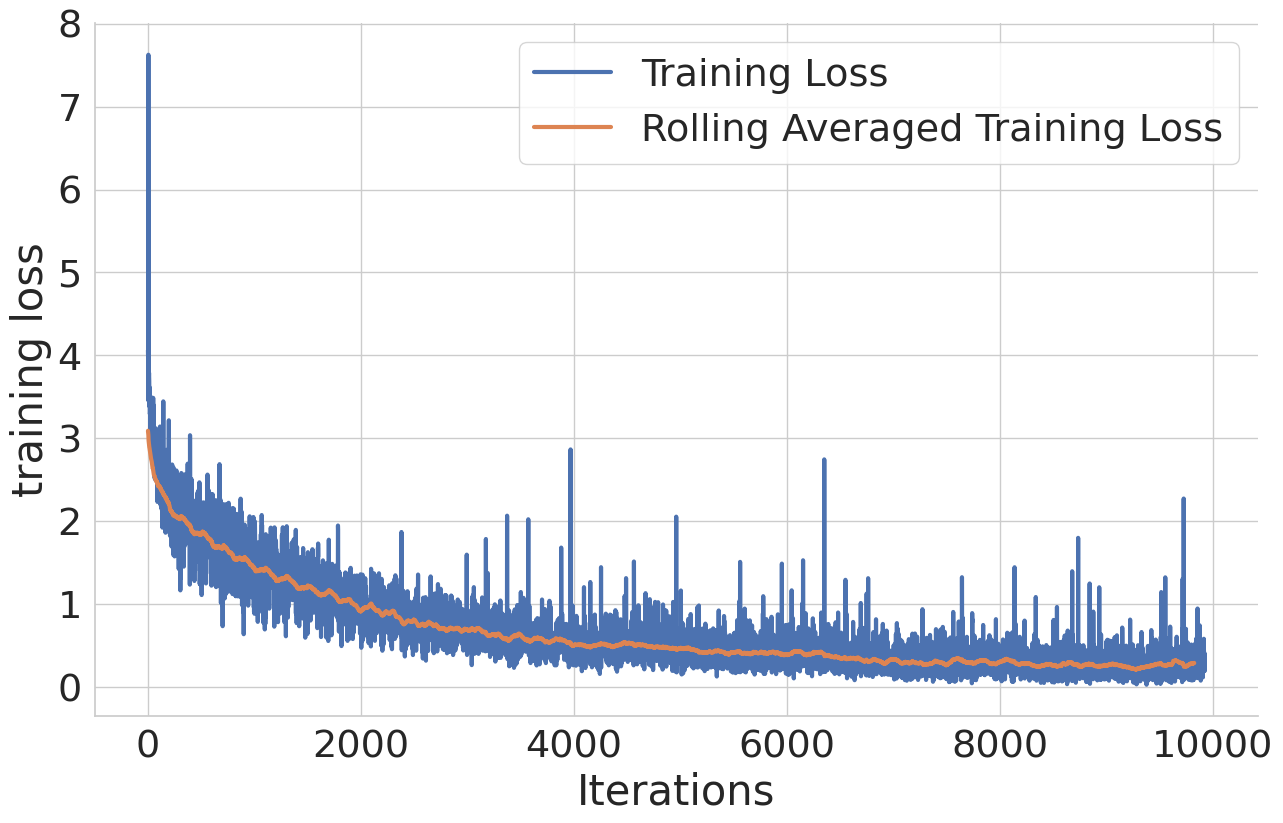

In [14]:
# Plot the training loss and rolling mean training loss with respect to iterations
plt.figure(figsize = (15, 9))

plt.plot(train_loss_list, linewidth = 3, label = 'Training Loss')
plt.plot(np.convolve(train_loss_list, np.ones(100), 'valid') / 100, 
         linewidth = 3, label = 'Rolling Averaged Training Loss')
plt.ylabel("training loss")
plt.xlabel("Iterations")
plt.legend()
sns.despine()